# **Kaggle Competition 데이터셋을 활용한 LSTM 실습**

https://www.kaggle.com/competitions/m5-forecasting-accuracy/data

## **전반적인 Sequential Data Analysis 과정**

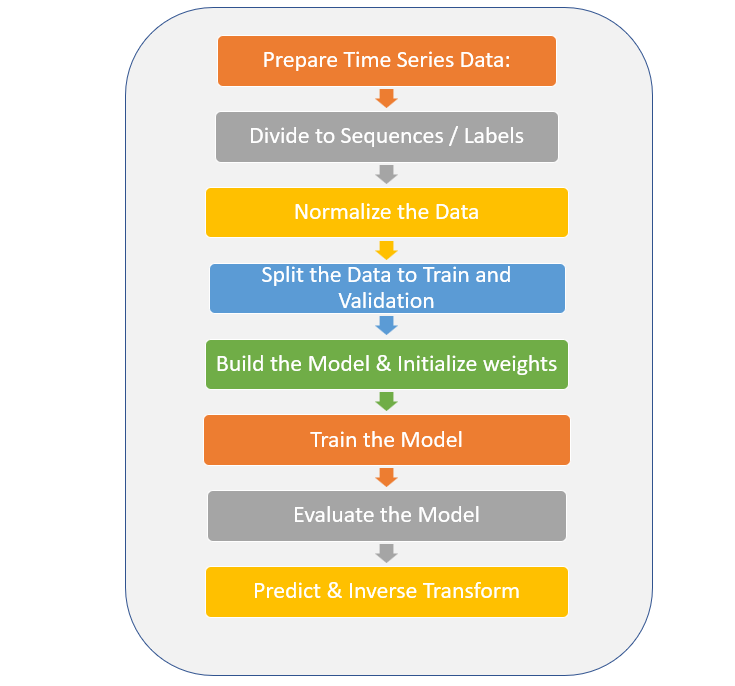

## **Google Drive Mount 하기**

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

## **사용할 라이브러리 불러오기**

In [ ]:
import time
import os
import warnings
import random
import datetime as dt
from itertools import cycle

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tqdm import tqdm

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.nn as nn

### **라이브러리 및 환경 세팅 진행 (Optional)**

In [ ]:
%matplotlib inline

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

In [ ]:
plt.style.use("bmh")
colorPal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colorCycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## **사용 Device 정하기 (GPU 또는 CPU)**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(f"Device Type : {device}")

## **데이터 읽어오기**

In [ ]:
!unzip "/content/gdrive/MyDrive/LSTMTracking/dataset/m5-forecasting-accuracy.zip"

### **효율적 데이터 처리를 위한 함수 작성 (Optional)**

In [ ]:
def reduceMemUsage(df, verbose=True) :
  numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
  startMem = df.memory_usage().sum()/1024**2

  for col in df.columns :
    colType = df[col].dtypes
    if colType in numerics :
      colMin = df[col].min()
      colMax = df[col].max()
      if str(colType)[:3] == "int" :
        if colMin > np.iinfo(np.int8).min and colMax < np.iinfo(np.int8).max :
            df[col] = df[col].astype(np.int8)
        elif colMin > np.iinfo(np.int16).min and colMax < np.iinfo(np.int16).max :
            df[col] = df[col].astype(np.int16)
        elif colMin > np.iinfo(np.int32).min and colMax < np.iinfo(np.int32).max :
            df[col] = df[col].astype(np.int32)
        elif colMin > np.iinfo(np.int64).min and colMax < np.iinfo(np.int64).max :
            df[col] = df[col].astype(np.int64)
      else:
        if colMin > np.finfo(np.float16).min and colMax < np.finfo(np.float16).max :
            df[col] = df[col].astype(np.float16)
        elif colMin > np.finfo(np.float32).min and colMax < np.finfo(np.float32).max :
            df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype(np.float64)

  endMem = df.memory_usage().sum()/1024**2

  if verbose :
    print(f"[Memory Usage] Decreased to {endMem:.2f} Mb ({(100*(startMem-endMem)/startMem):.2f}% Reduction)")

  return df

In [ ]:
def readData() :
  sellPricesDF = pd.read_csv("sell_prices.csv")
  sellPricesDF = reduceMemUsage(sellPricesDF)
  print(f"<Sell Prices> : {sellPricesDF.shape[0]} Rows x {sellPricesDF.shape[1]} Columns")

  calendarDF = pd.read_csv("calendar.csv")
  calendarDF = reduceMemUsage(calendarDF)
  print(f"<Calendar> : {calendarDF.shape[0]} Rows x {calendarDF.shape[1]} Columns")

  salesTrainValidDF = pd.read_csv("sales_train_validation.csv")
  print(f"<Sales Train Validation> : {salesTrainValidDF.shape[0]} Rows x {salesTrainValidDF.shape[1]} Columns")

  submissionDF = pd.read_csv("sample_submission.csv")

  return sellPricesDF, calendarDF, salesTrainValidDF, submissionDF

In [ ]:
_, calendarDF, salesTrainValidDF, _ = readData()

### **Date 리스트 추가**

In [ ]:
dateIndex = calendarDF["date"]
dates = dateIndex[0:1913]
datesList = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [ ]:
for i in range(10) :
  print(datesList[i])

## **데이터셋 시각화 (시계열)**

In [ ]:
salesTrainValidDF["item_store_id"] = salesTrainValidDF.apply(lambda x: x["item_id"] + "_" + x["store_id"], axis=1)
salesDF = salesTrainValidDF.loc[:,"d_1":"d_1913"].T
salesDF.columns = salesTrainValidDF["item_store_id"].values

In [ ]:
salesDF = pd.DataFrame(salesDF).set_index([datesList])
salesDF.index = pd.to_datetime(salesDF.index)
salesDF.head(10)

In [ ]:
index = 6780

In [ ]:
y = pd.DataFrame(salesDF.iloc[:,index])
y = pd.DataFrame(y).set_index([datesList])
y.index = pd.to_datetime(y.index)

In [ ]:
ax = y.plot(figsize=(30, 9), color="red")
ax.set_facecolor("lightgrey")
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(fontsize=20)
plt.title(label="Sales Demand Selected Time Series Over Time", fontsize=23)
plt.ylabel(ylabel='Sales Demand',fontsize = 21)
plt.xlabel(xlabel='Date',fontsize = 21)
plt.show()

## **훈련 및 모델 하이퍼파라미터 선정**

In [ ]:
opt = {"seqLen":28, "inputSize":1, "hiddenSize":512, "numLayer":1, "numClass":1,
       "p":0.25, "numEpoch":500, "lr":1e-3, "seed":42}

## **시드 고정**

In [ ]:
def fixSeed(seed) :
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
fixSeed(opt["seed"])

## **데이터 전처리 과정**

### **Min-Max Normalization**

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1)) # (-1,1) 값으로 Normalization 진행

In [ ]:
data = np.array(y)
trainDataNormalized = scaler.fit_transform(data.reshape(-1, 1))

In [ ]:
print(f"Mininum Value : {trainDataNormalized.min()}")
print(f"Maximum Value : {trainDataNormalized.max()}")

### **데이터 분포 (Histogram) 시각화**

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle("Data Distribution Before and After Normalization",fontsize=19)
pd.DataFrame(data).plot(kind="hist",ax=axs[0], alpha=.4, figsize=[12,6], legend=False, title="Before Normalization", color='red')
pd.DataFrame(trainDataNormalized).plot(kind="hist", ax=axs[1], figsize=[12,6], alpha=.4, legend=False, title="After Normalization", color="blue")
plt.show()

## **Sequence 데이터 생성 단계**

### 기존 데이터

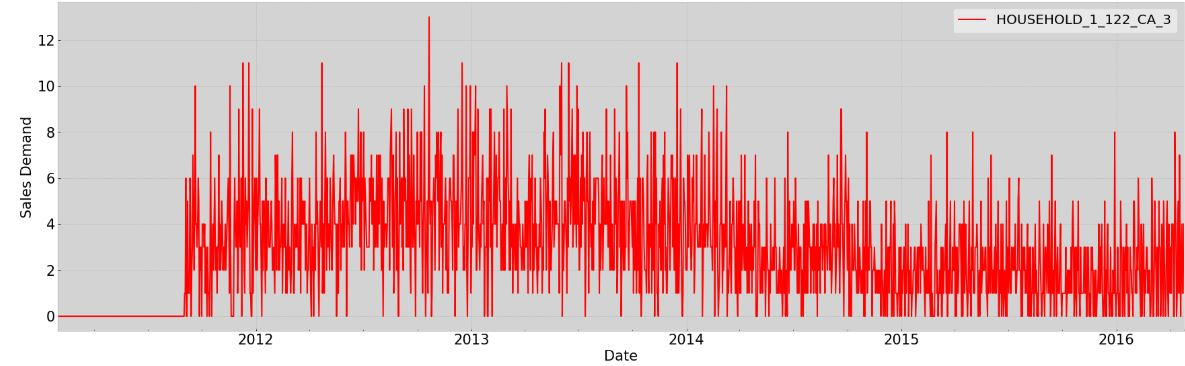

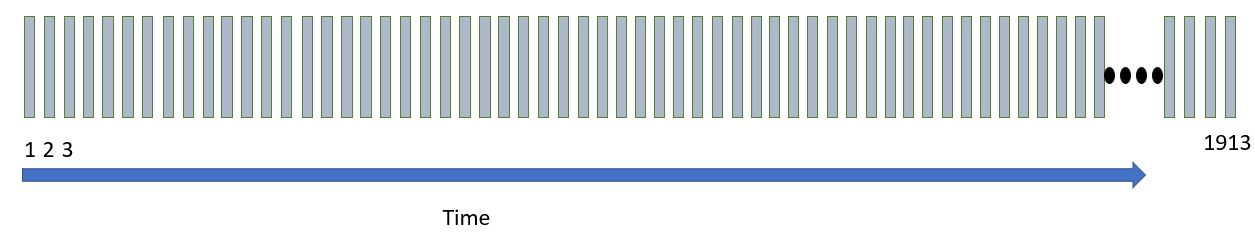

### 1-Step 이동하여 새로운 Input과 Label을 제작 (Sliding Window)

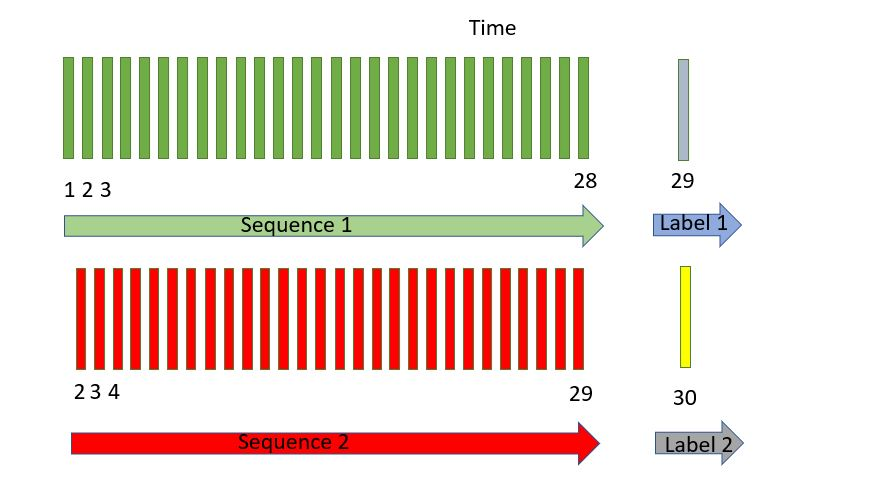

### **Seqeunce 데이터 생성**

In [ ]:
def slidingWindows(data, seqLen) :
  x, y = [], []

  for i in range(len(data)-seqLen-1) :
    x.append(data[i:(i+seqLen)])
    y.append(data[i+seqLen])

  return np.array(x),np.array(y)

In [ ]:
x, y = slidingWindows(trainDataNormalized, opt["seqLen"])

In [ ]:
print(f"Input Shape : {x.shape}")
print(f"Target Shape : {y.shape}")

## **PyTorch Tensor 형태의 데이터셋 생성**

In [ ]:
trainSize = int(len(y)*0.67)
testSize = len(y)-trainSize

In [ ]:
print(f"Train Dataset Size : {trainSize}")
print(f"Test Dataset Size : {testSize}")

### **PyTorch Tensor로 변환**

In [ ]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

### **데이터셋 Split 과정 진행**

In [ ]:
trainX = Variable(torch.Tensor(np.array(x[0:trainSize])))
trainY = Variable(torch.Tensor(np.array(y[0:trainSize])))

In [ ]:
testX = Variable(torch.Tensor(np.array(x[trainSize:len(x)])))
testY = Variable(torch.Tensor(np.array(y[trainSize:len(y)])))

In [ ]:
print(f"Train Dataset Input Size : {trainX.size()}")
print(f"Train Dataset Label Size : {trainY.size()}")
print(f"Test Dataset Input Size : {testX.size()}")
print(f"Test Dataset Label Size : {testY.size()}")

## **LSTM 모델 클래스 정의**

### 기본적인 1-Layer LSTM를 사용

#### Many-to-One 유형

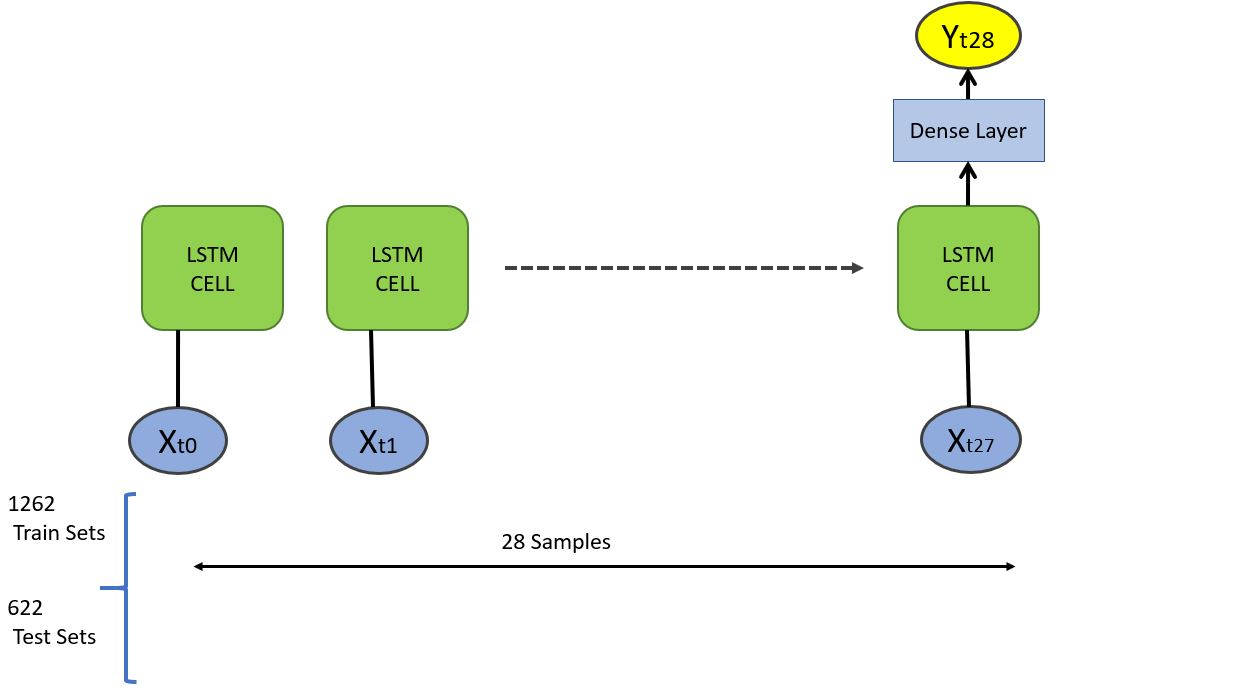

In [ ]:
class LSTM(nn.Module) :
    def __init__(self, inputSize, hiddenSize, numLayer, numClass, p) :
        # Inheritance
        super(LSTM, self).__init__()

        # Initialize Variables
        self.hiddenSize = hiddenSize
        self.numLayer = numLayer
        self.lstm = nn.LSTM(inputSize, hiddenSize, numLayer, batch_first=True, dropout=p)
        self.fc = nn.Linear(hiddenSize, numClass)
        self.dropout = nn.Dropout(p) # Overfitting을 방지하기 위한 Dropout

    def forward(self, input):
        h0 = torch.zeros(self.numLayer, input.size(0), self.hiddenSize).to(input.device)
        c0 = torch.zeros(self.numLayer, input.size(0), self.hiddenSize).to(input.device)

        output, _ = self.lstm(input, (h0, c0))
        output = self.fc(output[:, -1, :])
        output = self.dropout(output)

        return output

## **훈련 과정 요약을 위한 Average Meter 인스턴스 생성**

In [ ]:
class AverageMeter(object) :
  def __init__(self) :
    self.reset()

  def reset(self) :
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1) :
    self.val = val
    self.sum += val*n
    self.count += n
    self.avg = self.sum / self.count

In [ ]:
trainLoss, testLoss = AverageMeter(), AverageMeter()

## **훈련 결과 저장을 위한 Python List 인스턴스 생성**

In [ ]:
lstmTrainLossList, lstmTestLossList = [], []

In [ ]:
bestTestLoss = torch.inf

## **LSTM 모델 훈련**

### **LSTM 모델 인스턴스 생성**

In [ ]:
fixSeed(opt["seed"])

In [ ]:
model = LSTM(opt["inputSize"], opt["hiddenSize"], opt["numLayer"], opt["numClass"], opt["p"]).to(device)

### **LSTM 모델 파라미터 개수 계산**

In [ ]:
numParameter = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f"Numer of Trainable Parameters : {numParameter:,}")

### **손실 함수 인스턴스 생성**

In [ ]:
criterion = nn.MSELoss()

### **Optimizer 인스턴스 생성**

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=opt["lr"])

### **훈련 진행**

In [ ]:
with tqdm(total=opt["numEpoch"]) as pBar :
  for epoch in range(1, opt["numEpoch"]+1) :
    ########################################################################################################################################
      trainLoss.reset()

      model.train() # Train Mode

      trainX, trainY = trainX.to(device), trainY.to(device) # Assign Device

      optimizer.zero_grad() # Set Gradient to 0
      pred = model(trainX) # Get Prediction
      loss = criterion(pred, trainY) # Compute Loss
      loss.backward() # Back-Propagation
      optimizer.step() # Update Weight

      trainLoss.update(loss.detach().cpu().item()) # Compute Averaged Loss

      lstmTrainLossList.append(trainLoss.avg)

      ########################################################################################################################################

      model.eval() # Evaulation Mode

      testX, testY = testX.to(device), testY.to(device) # Assign Device

      with torch.no_grad() :
        pred = model(testX) # Get Prediction
        loss = criterion(pred, testY) # Compute Loss

        testLoss.update(loss.detach().cpu().item()) # Compute Averaged Loss

      lstmTestLossList.append(testLoss.avg)

      if testLoss.avg < bestTestLoss :
        bestTestLoss = testLoss.avg
        torch.save(model.state_dict(), "Best-LSTM.pth")

      torch.save(model.state_dict(), "Latest-LSTM.pth")

      pBar.set_description(f"[{epoch}/{opt['numEpoch']}] < Train Loss:{trainLoss.avg:.4f} | Test Loss:{testLoss.avg:.4f} >")
      pBar.update()

## **LSTM 모델 훈련 과정 시각화**

In [ ]:
plt.plot(np.arange(opt["numEpoch"]), lstmTrainLossList, label="Train Loss")
plt.plot(np.arange(opt["numEpoch"]), lstmTestLossList, label="Test Loss")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("[LSTM] Train Loss vs. Test Loss")
plt.show()

## **모델 성능 평가**

### **전체 데이터셋을 사용하여 추론 진행**

In [ ]:
model.eval()

In [ ]:
dataYPred = model(dataX.to(device))
dataYPred = dataYPred.cpu().data.numpy()
dataYGT = dataY.data.numpy()

In [ ]:
dataYPred = scaler.inverse_transform(dataYPred)
dataYGT = scaler.inverse_transform(dataYGT)

In [ ]:
dataYPred = pd.DataFrame(dataYPred)
dataYPred = dataYPred.set_index([datesList[:-29]])
dataYGT = pd.DataFrame(dataYGT)
dataYGT = dataYGT.set_index([datesList[:-29]])

### **추론 결과 시각화**

In [ ]:
plt.figure(num=None, figsize=(19,6), dpi=80, facecolor="w", edgecolor="k")
plt.axvline(x=datesList[trainSize], c="r")
plt.plot(dataYGT[0])
plt.plot(dataYPred[0])
plt.legend(["Prediction","Time Series"], fontsize=21)
plt.suptitle("Time-Series Prediction Entire Set", fontsize=23)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.ylabel(ylabel="Sales Demand", fontsize=21)
plt.xlabel(xlabel="Date", fontsize=21)
plt.show()

### **테스트 데이터셋을 사용한 추론 결과 시각화**

In [ ]:
plt.figure(num=None, figsize=(23,6), dpi=80, facecolor="w", edgecolor="k")
plt.plot(dataYGT.iloc[-testX.size()[0]:][0])
plt.plot(dataYPred.iloc[-testX.size()[0]:][0])
plt.legend(["Prediction','Time Series"], fontsize=21)
plt.suptitle("Time-Series Prediction Test", fontsize=23)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.ylabel(ylabel="Sales Demand", fontsize=21)
plt.xlabel(xlabel="Date", fontsize=21)
plt.show()

### **테스트 데이터셋을 사용한 추론 결과의 정량적 분석**

#### **RSME 계산**

In [ ]:
rmse = np.sqrt(np.power(dataYGT[-testX.size()[0]:]-dataYPred[-testX.size()[0]:], 2)).mean()[0]

In [ ]:
print(f"Test RMSE : {rmse:.4f}")

## **LSTM 모델 클래스 정의**

### Multiple-Layer LSTM를 사용

#### Many-to-One 유형

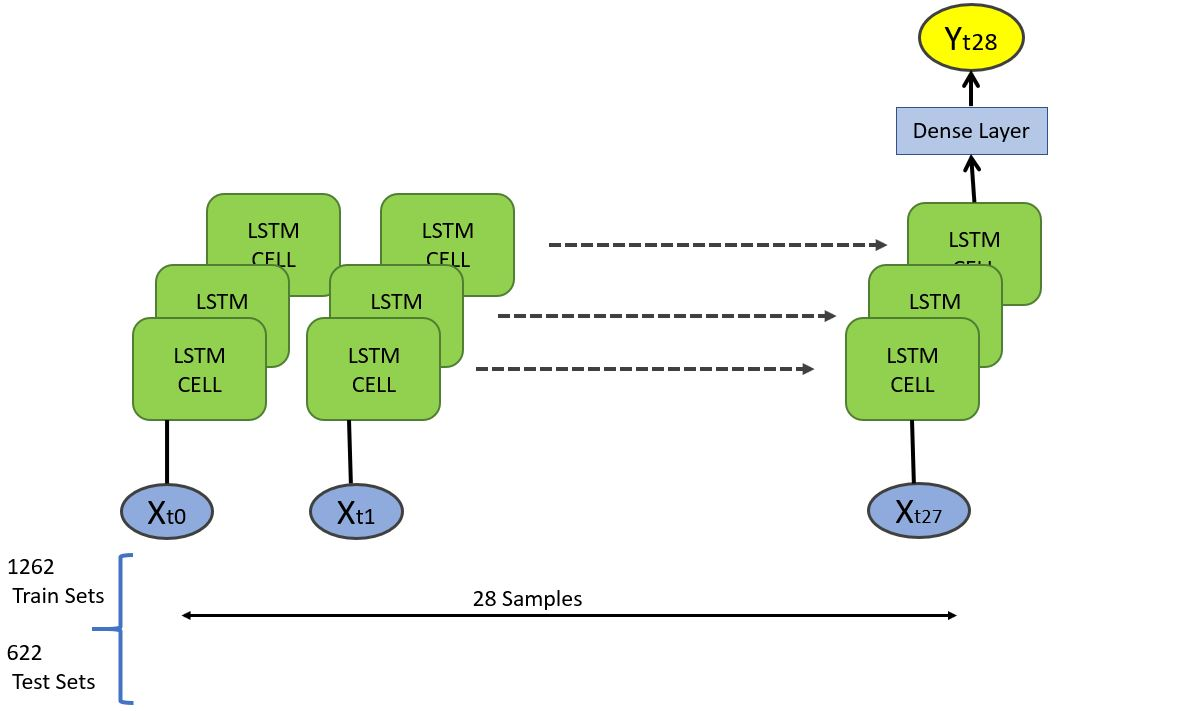

In [ ]:
class MultiLSTM(nn.Module) :
    def __init__(self, inputSize, hiddenSize, numLayer, numClass, p) :
        # Inheritance
        super(MultiLSTM, self).__init__()

        # Initialize Variables
        self.hiddenSize = hiddenSize
        self.numLayer = numLayer
        self.lstm = nn.LSTM(inputSize, hiddenSize, numLayer, batch_first=True, dropout=p)
        self.fc = nn.Linear(hiddenSize, numClass)
        self.dropout = nn.Dropout(p) # Overfitting을 방지하기 위한 Dropout

    def forward(self, input):
        h0 = torch.zeros(self.numLayer, input.size(0), self.hiddenSize).to(input.device)
        c0 = torch.zeros(self.numLayer, input.size(0), self.hiddenSize).to(input.device)

        output, _ = self.lstm(input, (h0, c0))
        output = self.fc(output[:, -1, :])
        output = self.dropout(output)

        return output

## **Multi-Layer LSTM 모델을 만드세요 (Layer=2)**

In [ ]:
# Option Dictionary 입력

## **LSTM 모델 훈련**

### **LSTM 모델 인스턴스 생성**

In [ ]:
# 시드 고정

In [ ]:
# 모델 인스턴스 생성

### **LSTM 모델 파라미터 개수 계산**

In [ ]:
# 모델 파라미터 계산

In [ ]:
# 모델 파라미터 개수 출력

### **손실 함수 인스턴스 생성**

In [ ]:
# MSE 손실 함수 인스턴스 생성

### **Optimizer 인스턴스 생성**

In [ ]:
# Adam Optimizer 인스턴스 생성

### **훈련 진행**

In [ ]:
# 모델 훈련 코드 작성

## **LSTM 모델 훈련 과정 시각화**

In [ ]:
# 훈련 과정 시각화 코드 작성

## **모델 성능 평가**

### **전체 데이터셋을 사용하여 추론 진행**

In [ ]:
# Evaluation Mode로 전환

In [ ]:
# Numpy Array로 데이터 타입 변환

In [ ]:
# Affine (Inverse) Transformation 적용

In [ ]:
# 끝에서 28번째 데이터까지만 사용

### **추론 결과 시각화**

In [ ]:
# 추론 결과 시각화 코드 작성

### **테스트 데이터셋을 사용한 추론 결과 시각화**

In [ ]:
# 추론 결과 시각화 코드 작성

### **테스트 데이터셋을 사용한 추론 결과의 정량적 분석**

#### **RSME 계산**

In [ ]:
# RMSE 계산 코드 작성

In [ ]:
# RMSE 결과 값 출력